# Import Library used in project

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# tokenize the document
from keras.preprocessing.text import text_to_word_sequence
# This must be list of strings
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Input, concatenate, Embedding, LSTM, GRU, Dense, Dropout, Flatten, Conv1D, BatchNormalization, MaxPooling1D
from tensorflow.keras.utils import plot_model
from keras.models import load_model

from gensim.models import Word2Vec
from gensim.corpora.dictionary import Dictionary
from collections import Counter
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
stop_words = stopwords.words('english')
#to fix imbalance in data 
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mahmoud\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# the dimension of word vector
vocab_dim = 256
# sentence length
maxlen = 150
# batch size
batch_size = 512
# epoch num
n_epoch = 30
# input length
input_length = 150

In [285]:
train_text = pd.read_csv('./emotion/train_text.txt',sep='\t',names=['Review'])
train_labels = pd.read_csv('./emotion/train_labels.txt',sep='\t',names=['Label'])
test_text = pd.read_csv('./emotion/test_text.txt',sep='\t',names=['Review'])
test_labels = pd.read_csv('./emotion/test_labels.txt',sep='\t',names=['Label'])
val_text = pd.read_csv('./emotion/val_text.txt',sep='\t',names=['Review'])
val_labels = pd.read_csv('./emotion/val_labels.txt',sep='\t',names=['Label'])

In [286]:
df1 = pd.concat([train_labels,test_labels,val_labels])
df2 = pd.concat([train_text,test_text,val_text])

In [287]:
df = pd.concat([df1,df2],axis=1)

In [288]:
# show value of counts for class labels
df.Label.value_counts()

0    2118
3    1326
1    1163
2     445
Name: Label, dtype: int64

In [289]:
df = df[df['Label']==0]

In [290]:
df['Label'] = 'anger'

In [291]:
df.head()

,Label,Review
1,anger,My roommate: it's okay that we can't spell bec...
3,anger,Rooneys fucking untouchable isn't he? Been fuc...
5,anger,@user but your pussy was weak from what I hear...
8,anger,@user broadband is shocking regretting signing...
9,anger,@user Look at those teef! #growl


In [332]:
df1 = pd.read_csv('tweet_emotions.csv')

In [333]:
df1.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [334]:
df1.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [335]:
df1 = df1[df1['sentiment'].isin(['neutral','happiness','sadness','anger'])]

In [336]:
df1.sentiment.value_counts()

neutral      8638
happiness    5209
sadness      5165
anger         110
Name: sentiment, dtype: int64

In [337]:
df1.drop('tweet_id',axis=1,inplace=True)

In [338]:
df1.rename(columns={'sentiment':'Label','content':'Review'},inplace=True)

In [299]:
# df = pd.concat([df1,df])

In [302]:
# df.Label.value_counts()

neutral      8638
happiness    5209
sadness      5165
anger        2228
Name: Label, dtype: int64

In [339]:
df = df1.copy()

In [340]:
df.head()

,Label,Review
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
4,neutral,@dannycastillo We want to trade with someone w...
6,sadness,"I should be sleep, but im not! thinking about ..."
8,sadness,@charviray Charlene my love. I miss you


<AxesSubplot:>

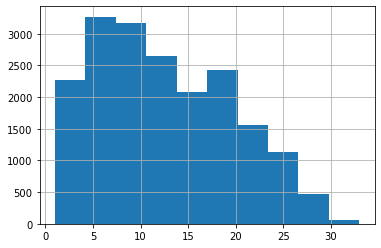

In [341]:
# Create a column containing the length of all words for each row
df['lenght'] = df.Review.apply(lambda x: len(x.split()))
df['lenght'].hist()

In [342]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input
longest_input = get_longest_text(df['Review'])
longest_input

33

# **Data preprocessing**

In [343]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

#remove_repeating_char
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

#processPost for applying all functions
def processPost(text): 
    #Replace @username with empty string
    text = re.sub('@[^\s]+', ' ', text)
    #Convert www.* or https?://* to " "
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',text)
    #Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)    
    return text
    
def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

# convert each word to lower case
def to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# replace all numbers with ''
def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)

# remove spaces from right and left sentences
def remove_whitespaces(text):
    return text.strip()

# remove stop words like the he she it for 
def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]

# return root of each word
def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

# return root of each word if word is Noun
def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

# return root of each word if word is Verb
def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

# split each sentence based on some features
def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

In [344]:
# create column contain clean code
df['clean_Review'] = df.Review.apply(lambda x: normalize_text(x))

<AxesSubplot:>

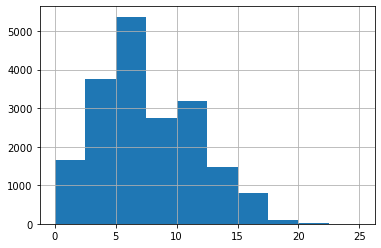

In [345]:
# Create a column containing the length of all words for each row
df['clean_lenght'] = df['clean_Review'].apply(lambda x: len(x.split()))
df['clean_lenght'].hist()

In [346]:
def get_longest_text(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text.split())
        longest_input = max(longest_input, text_len)
    return longest_input
longest_input = get_longest_text(df['clean_Review'])
longest_input

25

In [347]:
df.head()

,Label,Review,lenght,clean_Review,clean_lenght
1,sadness,Layin n bed with a headache ughhhh...waitin o...,10,layin n bed headache ughhhhwaitin call,6
2,sadness,Funeral ceremony...gloomy friday...,3,funeral ceremonygloomy friday,3
4,neutral,@dannycastillo We want to trade with someone w...,15,dannycastillo want trade someone houston ticke...,7
6,sadness,"I should be sleep, but im not! thinking about ...",26,sleep im think old friend want he marry damn w...,11
8,sadness,@charviray Charlene my love. I miss you,7,charviray charlene love miss,4


In [348]:
# show any row after apply clean sentences
df.clean_Review.iloc[np.random.randint(0,5000)]

'salary actually spend money hooray time go shop dinner ahora say goodbye yusufyusuf'

In [349]:
# create list sentences contain list of list of words [[],[],[]]
sentences = [i.split() for i in df.clean_Review]

In [350]:
words = [word for text in sentences for word in text]

In [351]:
# show most repeated word in text
from collections import Counter
word_counts = Counter(words)
word_counts.most_common(10)

[('get', 2053),
 ('im', 1976),
 ('go', 1906),
 ('day', 1572),
 ('good', 1106),
 ('work', 1081),
 ('like', 916),
 ('today', 819),
 ('u', 745),
 ('miss', 736)]

# **Word Embedding - Word2vec**

In [352]:
# create word 2 vec model to train on custom dataset
model = Word2Vec(sentences=sentences,size=vocab_dim, min_count=1, workers=6,iter=10)

In [353]:
model.train(sentences, total_examples=model.corpus_count, epochs=50)

(2585800, 2816300)

In [354]:
#show keys in text
# model.wv.vocab.keys()

In [355]:
# create one for each word in model 
gensim_dict = Dictionary()
gensim_dict.doc2bow(model.wv.vocab.keys(),allow_update=True)

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 1),
 (71, 1),
 (72, 1),
 (73, 1),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 1),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 1),
 (92, 1),
 (93, 1),
 (94, 1),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1),

In [356]:
# create Dictionary contain each word and index +1 for unknown value 
w2indx = {v: k + 1 for k, v in gensim_dict.items()}

In [357]:
# w2indx.keys()

In [358]:
# create Dictionary contain each word and vector from model 
w2vec = {word: model[word] for word in w2indx.keys()}

C:\Users\Mahmoud\AppData\Local\Temp/ipykernel_16268/2566026201.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2vec = {word: model[word] for word in w2indx.keys()}


In [359]:
# create data contain if word in model put index of it else put zero
data = []
for sentence in sentences:
    new_txt = []
    for word in sentence:
        try:
            new_txt.append(w2indx[word])
        except:
            new_txt.append(0)
    data.append(new_txt)


In [360]:
# pad 0 for all row in data matrix with maxlength to fix shape of all rows
matrix_data = pad_sequences(data,maxlen=maxlen,padding='post')

In [361]:
# create weight for embedding layer
n_symbols = len(w2indx) +1
embedding_weights = np.zeros((n_symbols,vocab_dim))
for word, index in w2indx.items():
    embedding_weights[index,:] = w2vec[word]

# **split data**

In [363]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df.Label)

In [364]:
x_train, x_validate, y_train, y_validate = train_test_split(matrix_data, y_encoded, test_size=0.2, random_state=42, stratify=df.Label)

# **Build Models**


In [365]:
class_len = len(df.Label.unique())

In [370]:
# Convolution
kernel_size = 5
filters = 64
pool_size = 4
model = Sequential()
model.add(Embedding(input_dim=n_symbols,input_length=input_length,mask_zero=True,weights=[embedding_weights],trainable=False,output_dim=vocab_dim))#No masking allowed for Conv1D
model.add(Dropout(0.5))
# model.add(Conv1D(filters,kernel_size,padding='same',activation='relu',strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
# model.add(Conv1D(filters,kernel_size,padding='valid',activation='relu',strides=1))
# model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(8))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(class_len,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 150, 256)          6853120   
                                                                 
 dropout_22 (Dropout)        (None, 150, 256)          0         
                                                                 
 lstm_7 (LSTM)               (None, 8)                 8480      
                                                                 
 batch_normalization_10 (Bat  (None, 8)                32        
 chNormalization)                                                
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 dense_18 (Dense)            (None, 4)                 36        
                                                     

In [371]:
# plot_model(model)

In [372]:
# #early stop to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
# #save best models in training
# chkpt = ModelCheckpoint("./model.h5", monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True, mode='max')
# #reduce learing rate each 5 epoch
ReduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=10, min_lr=0.001)
# #combine all callbacks
callbacks = [early_stopping, ReduceLR]

In [373]:
# train model
history = model.fit(matrix_data, y_encoded,validation_split=.15,epochs=n_epoch,batch_size=batch_size,verbose=1,callbacks=callbacks)#

Epoch 1/30
32/32 [==============================] - 20s 467ms/step - loss: 1.7757 - accuracy: 0.2918 - val_loss: 1.3966 - val_accuracy: 0.2224 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - 10s 324ms/step - loss: 1.5407 - accuracy: 0.3443 - val_loss: 1.3355 - val_accuracy: 0.2963 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - 12s 391ms/step - loss: 1.4323 - accuracy: 0.3778 - val_loss: 1.2807 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 4/30
32/32 [==============================] - 12s 394ms/step - loss: 1.3720 - accuracy: 0.3992 - val_loss: 1.2285 - val_accuracy: 0.4374 - lr: 0.0010
Epoch 5/30
32/32 [==============================] - 10s 316ms/step - loss: 1.3028 - accuracy: 0.4306 - val_loss: 1.1827 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 6/30
32/32 [==============================] - 12s 393ms/step - loss: 1.2550 - accuracy: 0.4584 - val_loss: 1.1451 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 7/30
32/32 [==============================] - 10s 326ms/st

# **Performance evaluation**

In [112]:
loss, accuracy = model.evaluate(x_validate,y_validate,batch_size=512)
print('Accuracy: %f' % (accuracy*100))

16/16 [==============================] - 0s 22ms/step - loss: 1.2102 - accuracy: 0.7122
Accuracy: 71.216100


# **show classification report and confusion matrix**

In [ ]:
out = model.predict(x_validate)#predict on validation data
model_y_pred = np.argmax(out,axis=1)

In [ ]:
def show_report_con(y_pred):
    print(classification_report(y_validate,y_pred))
    label = ['course content', 'structure', 'instructor', 'price', 'speed']
    cm = confusion_matrix(y_validate,y_pred,normalize='true')
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(label)
    ax.yaxis.set_ticklabels(label)
    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 

              precision    recall  f1-score   support

           0       0.12      0.02      0.04       230
           1       0.00      0.00      0.00       197
           2       0.00      0.00      0.00       436
           3       0.35      0.05      0.09      1481
           4       0.73      0.99      0.84      5657

    accuracy                           0.71      8001
   macro avg       0.24      0.21      0.19      8001
weighted avg       0.58      0.71      0.61      8001



Text(0.5, 1.0, 'Confusion Matrix')

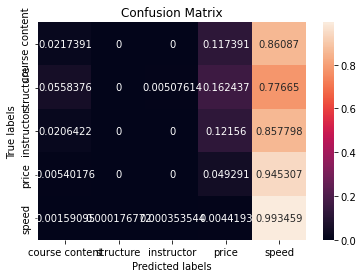

In [113]:
show_report_con(model_y_pred)

# **Plot accuracy**

In [ ]:
# summarize history for acc
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

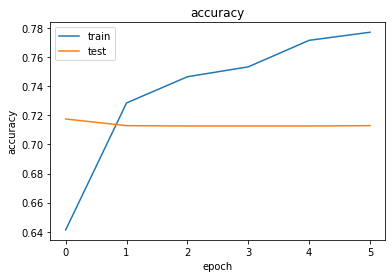

In [115]:
plot_acc(history)

# **Plot losses**

In [ ]:
# summarize history for loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

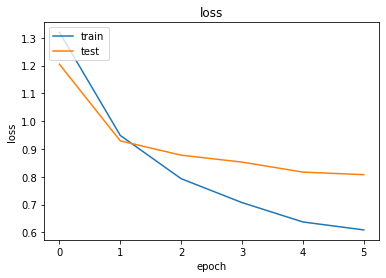

In [116]:
plot_loss(history)

In [ ]:
def print_acc_pre_rec_f1(y_pred):
    # accuracy: (tp + tn) / (p + n)
    model_accuracy = accuracy_score(y_validate, y_pred)
    print(model_accuracy)
    # precision tp / (tp + fp)
    model_precision = precision_score(y_validate, y_pred,average='macro')
    print(model_precision)
    # recall: tp / (tp + fn)
    model_recall = recall_score(y_validate, y_pred,average='macro')
    print(model_recall)
    # f1: 2 tp / (2 tp + fp + fn)
    model_f1 = f1_score(y_validate, y_pred,average='macro')
    print(model_f1)

In [117]:
print_acc_pre_rec_f1(model_y_pred)

0.7121609798775154
0.2384592210027975
0.2128979161619707
0.19235698878192345


# **another models**

# CNN

In [155]:
# define the network
inputs = Input((input_length, 1))
filters = [2, 3, 4]

# define the conv net
conv_1 = Conv1D(64, (filters[0]), activation='relu')(inputs)
conv_2 = Conv1D(64, (filters[1]), activation='relu')(inputs)
conv_3 = Conv1D(64, (filters[2]), activation='relu')(inputs)

# define max-pooling
pool_1 = MaxPooling1D(filters[0])(conv_1)
pool_2 = MaxPooling1D(filters[1])(conv_2)
pool_3 = MaxPooling1D(filters[2])(conv_3)

# concatenate the convs
merged_tensor = concatenate([pool_1, pool_2, pool_3], axis=1)

# now flatten them and add a dense layer
flatten = Flatten()(merged_tensor)

# add a dense layer
clf = Dense(32, activation='relu')(flatten)

# add final output
clf = Dense(class_len, activation='softmax')(clf)
# compile the model
cnn_model = Model(inputs, clf)
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 1)]     0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 149, 64)      192         ['input_2[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 148, 64)      256         ['input_2[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 147, 64)      320         ['input_2[0][0]']                
                                                                                            

In [156]:
plot_model(cnn_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [157]:
#early stop to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
#save best models in training
chkpt = ModelCheckpoint("./cnn_model.h5", monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True, mode='max')
#reduce learing rate each 5 epoch
ReduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=10, min_lr=0.001)
#combine all callbacks
callbacks = [early_stopping, ReduceLR]

In [158]:
cnn_history = cnn_model.fit(matrix_data, df.Label,validation_split=.15,epochs=n_epoch,batch_size=batch_size,verbose=1,callbacks=callbacks)

Epoch 1/30
9/9 [==============================] - 2s 137ms/step - loss: 270.3646 - accuracy: 0.3172 - val_loss: 117.2752 - val_accuracy: 0.2810 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - 0s 54ms/step - loss: 91.5002 - accuracy: 0.2811 - val_loss: 61.0635 - val_accuracy: 0.3166 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - 0s 55ms/step - loss: 57.1616 - accuracy: 0.3402 - val_loss: 32.4632 - val_accuracy: 0.3285 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - 0s 51ms/step - loss: 31.1634 - accuracy: 0.3067 - val_loss: 28.2625 - val_accuracy: 0.2968 - lr: 0.0010
Epoch 5/30
9/9 [==============================] - 0s 51ms/step - loss: 24.5794 - accuracy: 0.3239 - val_loss: 27.0263 - val_accuracy: 0.2665 - lr: 0.0010
Epoch 6/30
9/9 [==============================] - 0s 55ms/step - loss: 20.6185 - accuracy: 0.3174 - val_loss: 16.4929 - val_accuracy: 0.2942 - lr: 0.0010
Epoch 7/30
9/9 [==============================] - 1s 59ms/step - loss: 18

# **Performance evaluation**

In [127]:
loss, accuracy = cnn_model.evaluate(x_validate,y_validate,batch_size=512)
print('Accuracy: %f' % (accuracy*100))

16/16 [==============================] - 0s 12ms/step - loss: 1.5728 - accuracy: 0.7070
Accuracy: 70.703661


In [ ]:
out = cnn_model.predict(x_validate)
cnn_model_y_pred = np.argmax(out,axis=1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.00      0.00      0.00       197
           2       0.00      0.00      0.00       436
           3       0.00      0.00      0.00      1481
           4       0.71      1.00      0.83      5657

    accuracy                           0.71      8001
   macro avg       0.14      0.20      0.17      8001
weighted avg       0.50      0.71      0.59      8001



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

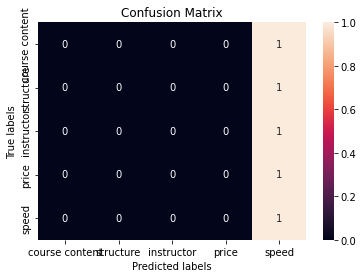

In [128]:

show_report_con(cnn_model_y_pred)

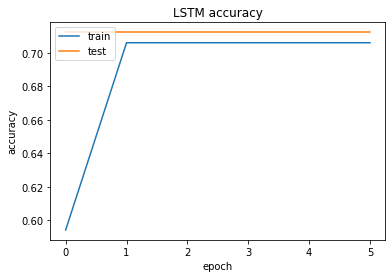

In [129]:
plot_acc(cnn_history)

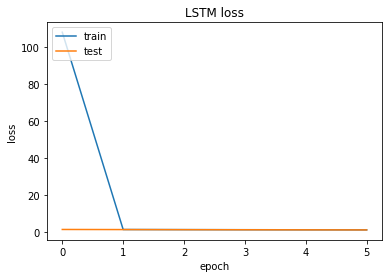

In [ ]:
plot_loss(cnn_history)

In [131]:
print_acc_pre_rec_f1(cnn_model_y_pred)

0.7070366204224472
0.14140732408448944
0.2
0.1656757944062088


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN 3 (Another Structure)

In [159]:
import tensorflow as tf

# define the network
inputs = tf.keras.layers.Input((input_length, 1))

filters_1 = [7, 5]
filters_2 = [3, 2]

# define the first convnets
convs_1 = []
for filter_size in filters_1:
    conv = tf.keras.layers.Conv1D(64, (filter_size), activation='relu')(inputs)
    pool = tf.keras.layers.MaxPooling1D(filter_size)(conv)
    convs_1.append(pool)
    
# concatenate the convs
character_level_features = tf.keras.layers.concatenate(convs_1, axis=1)

# define the second convnets
convs_2 = []
for filter_size in filters_2:
    conv = tf.keras.layers.Conv1D(128, (filter_size), activation='relu')(character_level_features)
    pool = tf.keras.layers.MaxPooling1D(filter_size)(conv)
    convs_2.append(pool)

# merge again 
word_level_features = tf.keras.layers.concatenate(convs_2, axis=1)

# now flatten them and add a dense layer
flatten = tf.keras.layers.Flatten()(word_level_features)

# add a dense layer
clf = tf.keras.layers.Dense(128, activation='relu')(flatten)

# add final output
clf = tf.keras.layers.Dense(class_len, activation='softmax')(clf)#n_classes
# compile the model
cnn1_model = tf.keras.models.Model(inputs, clf)
cnn1_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn1_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 1)]     0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 144, 64)      512         ['input_3[0][0]']                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 146, 64)      384         ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 20, 64)      0           ['conv1d_10[0][0]']              
 )                                                                                          

In [160]:
plot_model(cnn1_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [161]:
#early stop to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
#save best models in training
chkpt = ModelCheckpoint("/content/cnn1_model.h5", monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True, mode='max')
#reduce learing rate each 5 epoch
ReduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=10, min_lr=0.001)
#combine all callbacks
callbacks = [early_stopping, ReduceLR]

In [162]:
cnn1_history = cnn1_model.fit(matrix_data, df.Label,validation_split=.15,epochs=n_epoch,batch_size=batch_size,verbose=1,callbacks=callbacks)

Epoch 1/30
9/9 [==============================] - 5s 255ms/step - loss: 396.7303 - accuracy: 0.3041 - val_loss: 300.2878 - val_accuracy: 0.3813 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - 1s 72ms/step - loss: 202.5614 - accuracy: 0.3477 - val_loss: 94.7932 - val_accuracy: 0.2493 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - 1s 73ms/step - loss: 56.7378 - accuracy: 0.3114 - val_loss: 40.1809 - val_accuracy: 0.2573 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - 1s 72ms/step - loss: 30.6521 - accuracy: 0.2937 - val_loss: 18.1033 - val_accuracy: 0.3456 - lr: 0.0010
Epoch 5/30
9/9 [==============================] - 1s 73ms/step - loss: 18.6117 - accuracy: 0.3531 - val_loss: 16.3603 - val_accuracy: 0.3008 - lr: 0.0010
Epoch 6/30
9/9 [==============================] - 1s 78ms/step - loss: 12.6573 - accuracy: 0.3279 - val_loss: 10.9059 - val_accuracy: 0.3140 - lr: 0.0010


# **Performance evaluation**

In [136]:
loss, accuracy = cnn1_model.evaluate(x_validate,y_validate,batch_size=512)
print('Accuracy: %f' % (accuracy*100))

16/16 [==============================] - 0s 25ms/step - loss: 1.4538 - accuracy: 0.7070
Accuracy: 70.703661


In [ ]:
out = cnn1_model.predict(x_validate)
cnn1_model_y_pred = np.argmax(out,axis=1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.00      0.00      0.00       197
           2       0.00      0.00      0.00       436
           3       0.00      0.00      0.00      1481
           4       0.71      1.00      0.83      5657

    accuracy                           0.71      8001
   macro avg       0.14      0.20      0.17      8001
weighted avg       0.50      0.71      0.59      8001



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix')

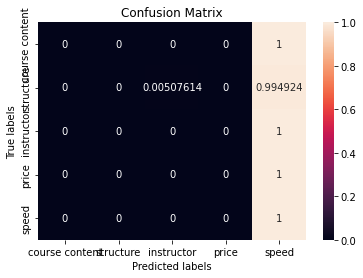

In [137]:
show_report_con(cnn1_model_y_pred)

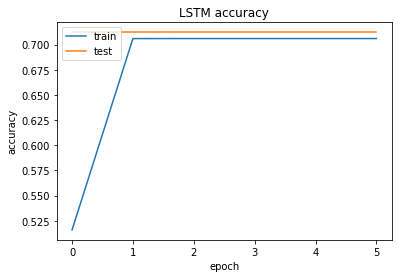

In [138]:
plot_acc(cnn1_history)

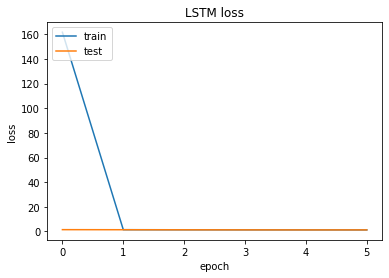

In [139]:
plot_loss(cnn1_history)

In [140]:
print_acc_pre_rec_f1(cnn1_model_y_pred)

0.7070366204224472
0.141425
0.2
0.1656879256059164


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# GRU

In [175]:
lstm_model =  Sequential()
#shape of embedding layer == np.zeros((n_symbols,input_length,vocab_dim)).shape (20, 350, 256)
lstm_model.add(Embedding(input_dim=n_symbols,input_length=input_length,
                         mask_zero=True,weights=[embedding_weights],output_dim=vocab_dim))
lstm_model.add(Dropout(0.5))
lstm_model.add(GRU(8))
lstm_model.add(BatchNormalization())
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(class_len,activation='softmax'))
lstm_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 256)          2386944   
                                                                 
 dropout_14 (Dropout)        (None, 150, 256)          0         
                                                                 
 gru_4 (GRU)                 (None, 8)                 6384      
                                                                 
 batch_normalization_6 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 4)                 36        
                                                      

In [176]:
#early stop to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)
#save best models in training
chkpt = ModelCheckpoint("./Dense.h5", monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True, mode='max')
#reduce learing rate each 5 epoch
ReduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,patience=10, min_lr=0.01)
#combine all callbacks
callbacks = [early_stopping, ReduceLR]

In [177]:
lstm_history = lstm_model.fit(matrix_data, df.Label,validation_split=.15,epochs=n_epoch,batch_size=batch_size,verbose=1,callbacks=callbacks)

Epoch 1/30
9/9 [==============================] - 9s 343ms/step - loss: 1.9301 - accuracy: 0.2646 - val_loss: 1.3648 - val_accuracy: 0.3127 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - 1s 83ms/step - loss: 1.6480 - accuracy: 0.3547 - val_loss: 1.2823 - val_accuracy: 0.4578 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - 1s 78ms/step - loss: 1.4743 - accuracy: 0.4073 - val_loss: 1.2283 - val_accuracy: 0.5396 - lr: 0.0010
Epoch 4/30
9/9 [==============================] - 1s 75ms/step - loss: 1.3928 - accuracy: 0.4523 - val_loss: 1.1907 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 5/30
9/9 [==============================] - 1s 75ms/step - loss: 1.3291 - accuracy: 0.4860 - val_loss: 1.1628 - val_accuracy: 0.5844 - lr: 0.0010
Epoch 6/30
9/9 [==============================] - 1s 77ms/step - loss: 1.2569 - accuracy: 0.5037 - val_loss: 1.1386 - val_accuracy: 0.6042 - lr: 0.0010
Epoch 7/30
9/9 [==============================] - 1s 77ms/step - loss: 1.2023 - accurac

# **Performance evaluation**

In [144]:
lstm_model.evaluate(x_validate,y_validate,batch_size=512)

16/16 [==============================] - 0s 25ms/step - loss: 0.6679 - accuracy: 0.7518


[0.6679186820983887, 0.7517810463905334]

In [ ]:
out = lstm_model.predict(x_validate)
lstm_model_y_pred = np.argmax(out,axis=1)

              precision    recall  f1-score   support

           0       0.50      0.40      0.44       230
           1       0.21      0.02      0.04       197
           2       0.30      0.23      0.26       436
           3       0.51      0.22      0.31      1481
           4       0.81      0.97      0.88      5657

    accuracy                           0.75      8001
   macro avg       0.46      0.37      0.38      8001
weighted avg       0.70      0.75      0.71      8001



Text(0.5, 1.0, 'Confusion Matrix')

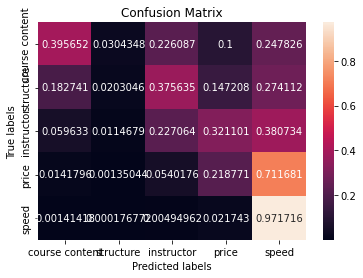

In [145]:
show_report_con(lstm_model_y_pred)

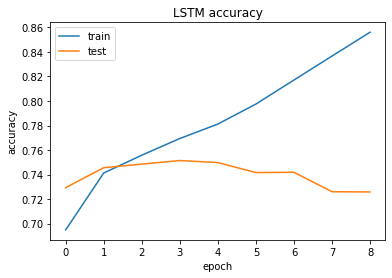

In [149]:
plot_acc(lstm_history)

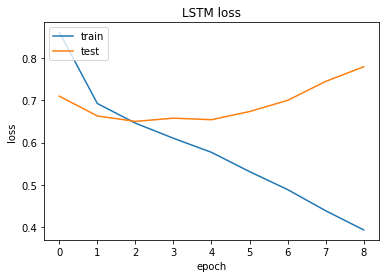

In [150]:
plot_loss(lstm_history)

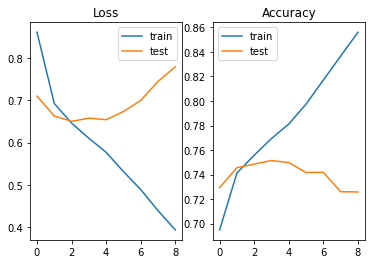

In [151]:
plt.subplot(121)
plt.title('Loss')
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(122)
plt.title('Accuracy')
plt.plot(lstm_history.history['accuracy'], label='train')
plt.plot(lstm_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

# compare between cnn and lstm algorthim

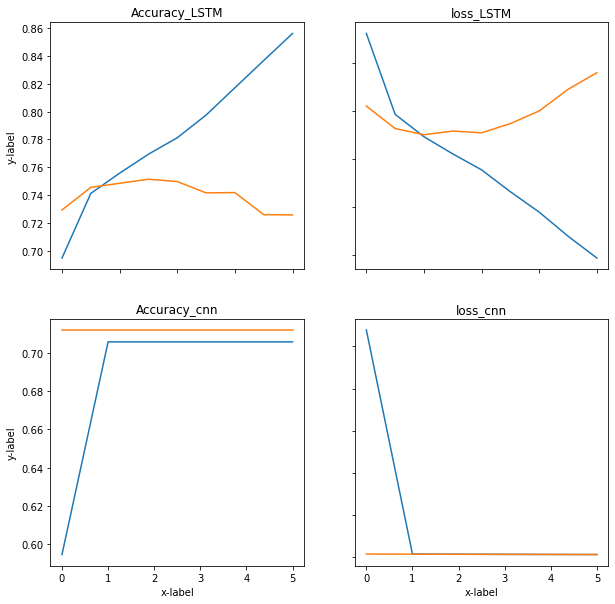

In [152]:
fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0, 0].plot(lstm_history.history['accuracy'], label='train')
axs[0, 0].plot(lstm_history.history['val_accuracy'], label='test')
axs[0, 0].set_title('Accuracy_LSTM')

axs[0, 1].plot(lstm_history.history['loss'], label='train')
axs[0, 1].plot(lstm_history.history['val_loss'], label='test')
axs[0, 1].set_title('loss_LSTM')

axs[1, 0].plot(cnn_history.history['accuracy'], label='train')
axs[1, 0].plot(cnn_history.history['val_accuracy'], label='test')
axs[1, 0].set_title('Accuracy_cnn')
axs[1, 1].plot(cnn_history.history['loss'], label='train')
axs[1, 1].plot(cnn_history.history['val_loss'], label='test')
axs[1, 1].set_title('loss_cnn')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

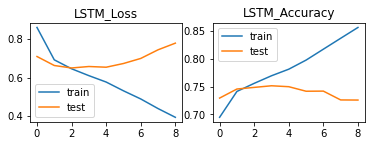

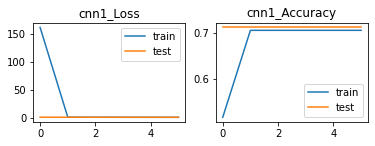

In [153]:
plt.subplot(221)
plt.title('LSTM_Loss')
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(222)
plt.title('LSTM_Accuracy')
plt.plot(lstm_history.history['accuracy'], label='train')
plt.plot(lstm_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
plt.subplot(223)
plt.title('cnn1_Loss')
plt.plot(cnn1_history.history['loss'], label='train')
plt.plot(cnn1_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(224)
plt.title('cnn1_Accuracy')
plt.plot(cnn1_history.history['accuracy'], label='train')
plt.plot(cnn1_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Machine Learning Algorthim

In [154]:
!pip install catboost

In [178]:
# classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [179]:
label = ['course content', 'structure', 'instructor', 'price', 'speed']

# logistic regression

In [180]:
#init logistic regression model
LogisticRegression_model = LogisticRegression()
#fit it on train data
LogisticRegression_model.fit(x_train, y_train)
#predict on validation data
LogisticRegression_model_y_pred = LogisticRegression_model.predict(x_validate)

C:\Users\Mahmoud\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [182]:

print('Accuracy:',accuracy_score(y_validate, LogisticRegression_model_y_pred))
# show_report_con(LogisticRegression_model_y_pred)

Accuracy: 0.41938674579624136


In [38]:
print_acc_pre_rec_f1(LogisticRegression_model_y_pred)

0.7010373703287089
0.21632736682329762
0.20523607466267735
0.17862497396188076


# **another models**

# KNN

In [183]:
KNeighborsClassifier_model = KNeighborsClassifier()
KNeighborsClassifier_model.fit(x_train, y_train)
KNeighborsClassifier_model_y_pred = KNeighborsClassifier_model.predict(x_validate)

In [184]:
print('Accuracy:',accuracy_score(y_validate, KNeighborsClassifier_model_y_pred))
# show_report_con(KNeighborsClassifier_model_y_pred)

Accuracy: 0.37190900098911966


In [41]:
print_acc_pre_rec_f1(KNeighborsClassifier_model_y_pred)

0.6440444944381952
0.25483691191959157
0.22244509815028227
0.2238802548178611


# RandomForestClassifier

In [185]:
RandomForestClassifier_model = RandomForestClassifier()
RandomForestClassifier_model.fit(x_train, y_train)
RandomForestClassifier_model_y_pred = RandomForestClassifier_model.predict(x_validate)

In [186]:

print('Accuracy:',accuracy_score(y_validate, RandomForestClassifier_model_y_pred))
# show_report_con(RandomForestClassifier_model_y_pred)

Accuracy: 0.44906033630069236


In [50]:
print_acc_pre_rec_f1(RandomForestClassifier_model_y_pred)

0.6440444944381952
0.3298155921054399
0.2108040159598396
0.19149349403789875


# CatBoostClassifier

In [187]:
CatBoostClassifier_model = CatBoostClassifier(learning_rate= 0.05, depth= 8, l2_leaf_reg = 21, verbose=0)
CatBoostClassifier_model.fit(x_train, y_train)
CatBoostClassifier_model_y_pred = CatBoostClassifier_model.predict(x_validate)

In [188]:
print('Accuracy:',accuracy_score(y_validate, CatBoostClassifier_model_y_pred))
# show_report_con(CatBoostClassifier_model_y_pred)

Accuracy: 0.4411473788328388


In [45]:
print_acc_pre_rec_f1(CatBoostClassifier_model_y_pred)

0.707286589176353
0.2827775672603259
0.20372082788064683
0.1747598634505329


In [189]:
LGBMClassifier_model = LGBMClassifier()
LGBMClassifier_model.fit(x_train, y_train)
LGBMClassifier_model_y_pred = LGBMClassifier_model.predict(x_validate)

In [190]:
print('Accuracy:',accuracy_score(y_validate, LGBMClassifier_model_y_pred))
# show_report_con(LGBMClassifier_model_y_pred)

Accuracy: 0.4619188921859545


In [47]:
print_acc_pre_rec_f1(LGBMClassifier_model_y_pred)

0.7085364329458818
0.32258657926083945
0.21403499756411892
0.19619757288670675


In [ ]:
# define the model
XGBClassifier_model = XGBClassifier()
# fit the model on the training set
XGBClassifier_model.fit(x_train, y_train)
# make predictions on the test set
XGBClassifier_model_y_pred = XGBClassifier_model.predict(x_validate)

Accuracy: 0.7065366829146357
              precision    recall  f1-score   support

           0       0.07      0.00      0.01       230
           1       0.33      0.01      0.01       197
           2       0.00      0.00      0.00       436
           3       0.32      0.01      0.02      1481
           4       0.71      1.00      0.83      5657

    accuracy                           0.71      8001
   macro avg       0.29      0.20      0.17      8001
weighted avg       0.57      0.71      0.59      8001



Text(0.5, 1.0, 'Confusion Matrix')

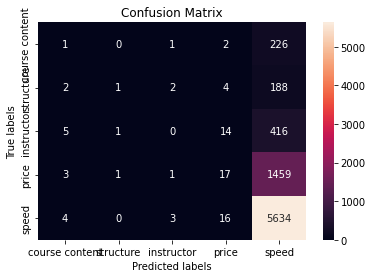

In [48]:
# calculate classification accuracy
print('Accuracy:',accuracy_score(y_validate, XGBClassifier_model_y_pred))
show_report_con(XGBClassifier_model_y_pred)

In [49]:
print_acc_pre_rec_f1(XGBClassifier_model_y_pred)

0.7065366829146357
0.2863697998899788
0.20336738791400655
0.17401543470383488
